In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import LSTM,RepeatVector,TimeDistributed
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D

tf.__version__

'2.3.1'

In [4]:
#!pip install tensorboard

%load_ext tensorboard # Load the TensorBoard notebook extension

ModuleNotFoundError: No module named 'tensorboard # Load the TensorBoard notebook extension'

## Autoencoders

* Unsupervised techniques that reconstructs the input using a hidden layer with fewer active units than the number of input units
    - Actually self-supervised since they use the input as the labels

![](Basic_Autoencoder.png)

* The middle layer is a bottleneck
    - In the figure above 4 input features are transformed into two latent features

* Tries to determine what are the most important features of the input.
    - Similar to PCA. 
    
    
#### Mapping

$$\text{Encoder: }\Phi: \mathcal{X} -> \mathcal{Z} \\
  \text{Decoder: }\Psi: \mathcal{Z} -> \mathcal{X} \\
  \Phi,\Psi =  \underset{\Phi,\Psi}{\mathrm{argmin}}||X - (\Psi\circ\Phi)X||^2$$
  
#### Encoder

* Encoder $\Phi$ maps input to latent space $\mathcal{Z}$, the bottleneck. $a_E$ is the activation function.
$$z = a_E(Wx + b)$$

#### Decoder

* Decoder $\Psi$ maps latent space $\mathcal{Z}$ to the output which is the same as the input. $a_D$ is the activation function.
$$x^{'} = a_D(Uz + c)$$


#### Properties:

* Data-specific: They are only be able to compress data similar to what they have been trained on.
* Lossy: The outputs will be degraded compared to the original inputs 
* Learned automatically from data examples

#### Hyperparameters

* The number of nodes in the middle layers
* Number of layers: Can have encoding and decoding layers around the middle layer
* Number of nodes per layer
* Loss function: Mean Squared Error or Binary Cross-entropy
    - if input values are [0,1] generally use cross-entropy
    
#### Uses

* Dimension Reduction
    - Similar to PCA but uses non-linear transformations
* Feature Detection
    - Eliminates correlation among predictors
* Recommender Systems


#### Types

* Basic 
* Sparse
* Denoising
* Stacked/Deep
* Convolutional


### Tensorflow2 Autoencoder

#### Preprocessing

* MINST dataset: handwritten digits 0 - 9

In [1]:
(X_train, _), (X_test, _) = mnist.load_data()  #Load data
X_train = X_train.astype('float32') / 255.     # Scale (0,1)
X_test = X_test.astype('float32') / 255.
X_train.shape, X_test.shape



NameError: name 'mnist' is not defined

In [4]:
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))  # Shape for Model
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


#### Build Model


In [5]:
input_dim  = 784
encoding_dim = 32               # Size of encoded representations (compression of factor 784/32 = 24.5)
output_dim = input_dim

input_img = Input(shape=(input_dim,)) # Input placeholder
encoded = Dense(encoding_dim, activation='relu')(input_img) # Encoded representation of the input
decoded = Dense(input_dim, activation='sigmoid')(encoded)         # Lossy reconstruction of the input

model = Model(input_img, decoded) # Model maps an input to its reconstruction

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [6]:
(784*32) + 32

25120

In [7]:
(32*784)+784

25872

In [8]:
print(f"input_img: {type(input_img)} \n encoded: {type(encoded)} \n decoded: {type(decoded)}")
input_img.shape, encoded.shape, decoded.shape

input_img: <class 'tensorflow.python.framework.ops.Tensor'> 
 encoded: <class 'tensorflow.python.framework.ops.Tensor'> 
 decoded: <class 'tensorflow.python.framework.ops.Tensor'>


(TensorShape([None, 784]), TensorShape([None, 32]), TensorShape([None, 784]))

#### Compile  and Fit Model

In [9]:
#optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
#model.compile(optimizer=optimizer, loss='binary_crossentropy')
model.compile(optimizer='adam', loss='binary_crossentropy')

In [10]:
#optimizer.learning_rate
model.optimizer.learning_rate

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>

#### Using tensorboard with the fit method

In [ ]:
#rm -rf ./logs/    # Remove previous logs
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [11]:
model.fit(X_train, X_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[tensorboard_callback]
               )

Epoch 1/10
235/235 [==============================] - 2s 8ms/step - loss: 0.2761 - val_loss: 0.1918
Epoch 2/10
235/235 [==============================] - 2s 9ms/step - loss: 0.1722 - val_loss: 0.1546
Epoch 3/10
235/235 [==============================] - 2s 8ms/step - loss: 0.1449 - val_loss: 0.1342
Epoch 4/10
235/235 [==============================] - 2s 8ms/step - loss: 0.1290 - val_loss: 0.1219
Epoch 5/10
235/235 [==============================] - 2s 7ms/step - loss: 0.1187 - val_loss: 0.1133
Epoch 6/10
235/235 [==============================] - 2s 7ms/step - loss: 0.1114 - val_loss: 0.1073
Epoch 7/10
235/235 [==============================] - 2s 7ms/step - loss: 0.1061 - val_loss: 0.1029
Epoch 8/10
235/235 [==============================] - 2s 7ms/step - loss: 0.1023 - val_loss: 0.0996
Epoch 9/10
235/235 [==============================] - 2s 7ms/step - loss: 0.0995 - val_loss: 0.0972
Epoch 10/10
235/235 [==============================] - 2s 7ms/step - loss: 0.0976 - val_loss: 0.0956

#### Start tensorboard

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
!ls logs.fit -al

#### Predict the test data 

In [12]:
decoded_imgs = model.predict(X_test)
print(decoded_imgs.shape)

(10000, 784)


#### Plot original and reconstructed images

In [13]:
def plot_images(x_test,decoded_imgs, n = 10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(X_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

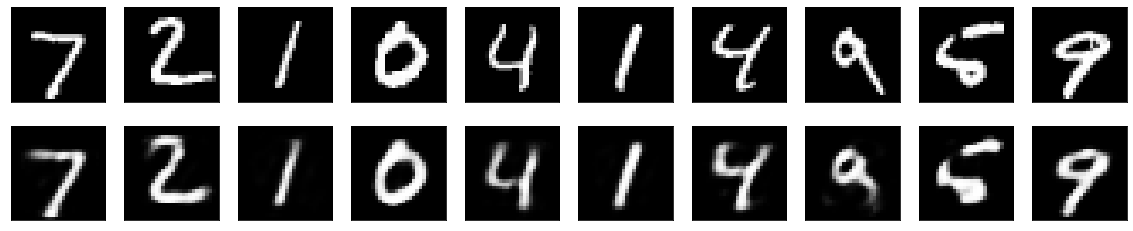

In [14]:
plot_images(X_test,decoded_imgs)

#### Encoder only model

In [15]:
model.layers

In [16]:
input_img = Input(shape=(input_dim,))
input_img

<tf.Tensor 'input_2:0' shape=(None, 784) dtype=float32>

In [17]:
encoder_layer = model.layers[1]
encoder = Model(input_img, encoder_layer(input_img))
encoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________


In [18]:
encoded_imgs = encoder.predict(X_test)
encoded_imgs.shape

(10000, 32)

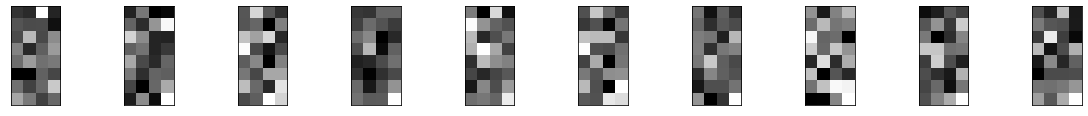

In [19]:
plt.figure(figsize=(20, 4))
n = 10
for i in range(n):
    # display encoded
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(encoded_imgs[i].reshape(8,4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### Sparse Autoencoder

* Usually has more hidden units than input units but only some of the hidden unit are active during any feed forward operation
* Used for feature extraction
* Two ways to impose sparsity constraints (i.e. types of regularization)
    - L1
    - KL-divergence

![](Sparse_Autoencoder.png)

### Build Model

#### Regularizers

* Regularizers allow to apply penalties on layer parameters or layer activity during optimization.
* The penalties are incorporated in the loss function that the network optimizes.

* Dense Layer Regularizer: activity_regularizer keyword
    - https://keras.io/layers/core/

In [20]:
# Sparse Autoencoder

encoding_dim = 32

input_img = Input(shape=(784,))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-6))(input_img)  # L1 regularization
decoded = Dense(784, activation='sigmoid')(encoded)

model = Model(input_img, decoded)

#### Comple and fit model

In [21]:
model.compile(optimizer='adam', loss='binary_crossentropy')

In [22]:
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_3 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.fit(X_train, X_train,epochs=10)

Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1632
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1067A: 0s
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0987
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0971
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0964
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0961
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0958
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0956
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0955
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0953


#### Predict test images and plot

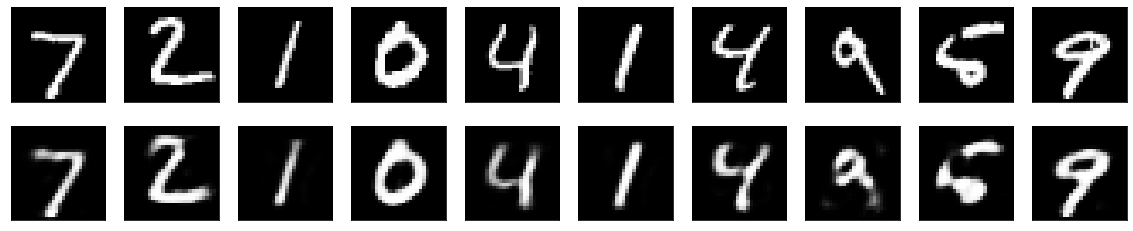

In [24]:
decoded_imgs = model.predict(X_test)
plot_images(X_test,decoded_imgs)

### Denoising Autoencoder

* Reconstruct data from an input of corrupted data
    - Prevents just "memorizing" the input
* Inputs are randomly removed (i.e. set to zero)
* Layers
    - Encoder
    - Code: Hiddden layer between encoder and decoder
    - Decoder

![](Denoising.png)



In [25]:
noise_factor = 0.4
X_train_noisy = X_train + noise_factor * np.random.normal(size=X_train.shape) 
X_test_noisy = X_test + noise_factor * np.random.normal(size=X_test.shape)

X_train_noisy = np.clip(X_train_noisy, 0.0, 1.0)
X_test_noisy = np.clip(X_test_noisy, 0.0, 1.0)

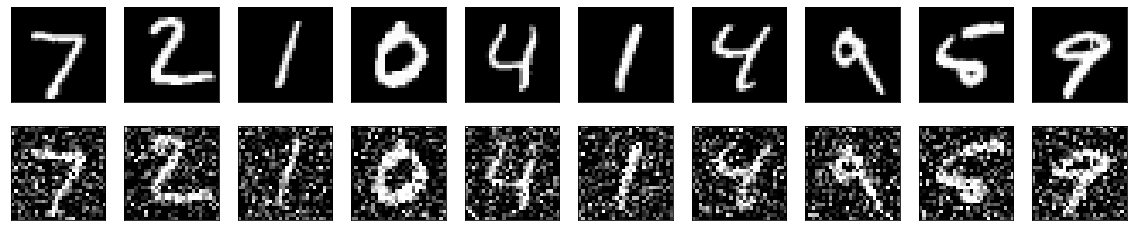

In [26]:
plot_images(X_test,X_test_noisy)

In [27]:
input_size = 784
hidden_size = 128
code_size = 32

input_img = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(input_img)
code = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(code)
output_img = Dense(input_size, activation='sigmoid')(hidden_2)

model = Model(input_img, output_img)

model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_5 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_6 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_7 (Dense)              (None, 784)               101136    
Total params: 209,968
Trainable params: 209,968
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(optimizer='adam', loss='binary_crossentropy')
model.fit(X_train_noisy, X_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1662
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1313
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1250
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1219
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1195
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1173
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1154
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1141
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1129
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1115A: 0s


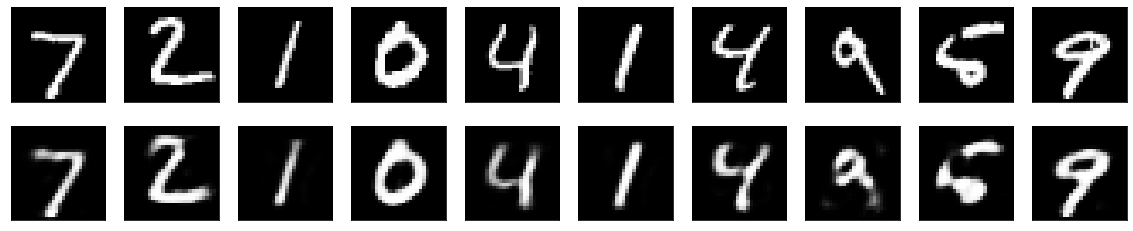

In [29]:
decoded_imsgs = model.predict(X_test_noisy)
plot_images(X_test,decoded_imgs)

### Stacked/Deep Autoencoder


#### Stacked/Deep Autoencoder

* More than 1 hidden layer

![](Stacked_Autoencoder.png)



In [30]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
code = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(code)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)
model = Model(input_img, decoded)
model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_12 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_13 (Dense)             (None, 784)              

In [31]:
model.compile(optimizer='adam', loss='binary_crossentropy')

model.fit(X_train, X_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/20
235/235 [==============================] - 3s 14ms/step - loss: 0.2351 - val_loss: 0.1600
Epoch 2/20
235/235 [==============================] - 3s 13ms/step - loss: 0.1462 - val_loss: 0.1337
Epoch 3/20
235/235 [==============================] - 3s 12ms/step - loss: 0.1288 - val_loss: 0.1218
Epoch 4/20
235/235 [==============================] - 3s 13ms/step - loss: 0.1202 - val_loss: 0.1167
Epoch 5/20
235/235 [==============================] - 3s 12ms/step - loss: 0.1148 - val_loss: 0.1111
Epoch 6/20
235/235 [==============================] - 3s 12ms/step - loss: 0.1099 - val_loss: 0.1070
Epoch 7/20
235/235 [==============================] - 3s 12ms/step - loss: 0.1060 - val_loss: 0.1029
Epoch 8/20
235/235 [==============================] - 3s 12ms/step - loss: 0.1032 - val_loss: 0.1007
Epoch 9/20
235/235 [==============================] - 3s 12ms/step - loss: 0.1009 - val_loss: 0.0986
Epoch 10/20
235/235 [==============================] - 3s 12ms/step - loss: 0.0991 - val_lo

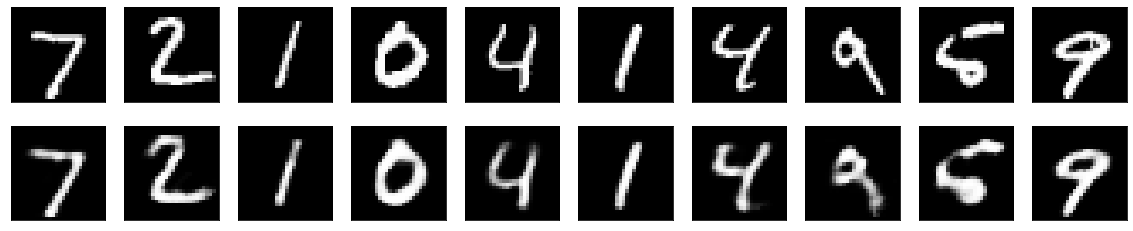

In [32]:
decoded_imgs = model.predict(X_test)


plot_images(X_test,decoded_imgs)

### Convolutional Autoencoder

![](ConvolAutoEncode.png)

* Tries to reconstruct the input image
* Replaces the fully-connected layer of a CNN
* Learns to remove noise from image
* Reconstruct missing parts

In [33]:
(X_train, _), (X_test, _) = mnist.load_data()  #Load data
X_train = X_train.astype('float32') / 255.     # Scale (0,1)
X_test = X_test.astype('float32') / 255.

In [34]:
X_train.shape,X_train.shape[1:],len(X_train)

((60000, 28, 28), (28, 28), 60000)

In [35]:
X_train = X_train.reshape(-1, 28,28, 1)
X_test = X_test.reshape(-1, 28,28, 1)
print(X_train.shape, X_test.shape)


(60000, 28, 28, 1) (10000, 28, 28, 1)


In [37]:
input_img = Input(shape=(28, 28,1))  

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)  # Repeats the rows and columns of the data by size[0] and size[1]
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

model = Model(input_img, decoded)
model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)         

In [38]:
model.compile(optimizer='adam', loss='binary_crossentropy')


In [39]:

model.fit(X_train, X_train,
                epochs=5,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test, X_test))


Epoch 1/5
469/469 [==============================] - 56s 120ms/step - loss: 0.2071 - val_loss: 0.1457
Epoch 2/5
469/469 [==============================] - 55s 117ms/step - loss: 0.1351 - val_loss: 0.1256
Epoch 3/5
469/469 [==============================] - 54s 114ms/step - loss: 0.1218 - val_loss: 0.1163
Epoch 4/5
469/469 [==============================] - 54s 115ms/step - loss: 0.1149 - val_loss: 0.1118
Epoch 5/5
469/469 [==============================] - 54s 115ms/step - loss: 0.1109 - val_loss: 0.1082


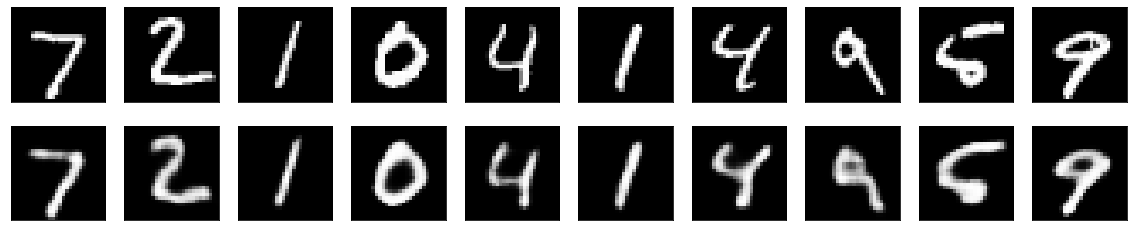

In [40]:

decoded_imgs = model.predict(X_test)
plot_images(X_test,decoded_imgs)

### References

https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798

https://blog.keras.io/building-autoencoders-in-keras.html

https://machinelearningmastery.com/lstm-autoencoders/

https://analyticsindiamag.com/how-to-implement-convolutional-autoencoder-in-pytorch-with-cuda/